**3. NLP Pipeline**

**- Sentiment Analysis and prediction using K Nearest Neighbor**


In [2]:
# Import Libraries

import numpy as np
import pandas as pd
import scipy
import itertools
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from math import sqrt
from collections import Counter
from random import choice
import nltk
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')

import string
import re
import textblob
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer() 

from wordcloud import ImageColorGenerator
from PIL import Image

import warnings
%matplotlib inline



c:\Users\pdhiman\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data

**Using Pickle to get the NLP Preprocessed tweets with Vader Sentiment Analysis**

In [3]:
# Loading All the tweets 

df = pd.read_pickle('source/nlp_sentiments.pkl')
df.head()

,Unnamed: 0,Date,ID,location,tweet,num_of_likes,num_of_retweet,language,cleaned_tweets,final_cleaned_tweets,sentiment_Original,sentiment_cleaned,sentiment_nlpfinal,vader_polarity
0,0,2022-11-07 23:59:59+00:00,1589769667765469186,"California, USA",Taking into account personal contributions &am...,2,1,en,taking account personal bad everyone better tr...,taking account personal bad everyone better tr...,positive,positive,positive,"{'neg': 0.271, 'neu': 0.403, 'pos': 0.326, 'co..."
1,1,2022-11-07 23:59:59+00:00,1589769667652235267,@jlo follows ♡ 01.29.21,whats your fav song?\n\n❥ I’m voting #Jennifer...,0,10,en,whats song voting,whats song voting,positive,neutral,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,2,2022-11-07 23:59:59+00:00,1589769667127934977,Unknown,@MayoIsSpicyy He is allowed to speak his opini...,0,0,en,speak opinion like rest us opinion vote republ...,speak opinion like rest u opinion vote republi...,negative,positive,positive,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp..."
3,3,2022-11-07 23:59:59+00:00,1589769666918244352,USA,HEY NY DISTRICT 10! PLEASE VOTE FOR @danielsgo...,1,1,en,hey district please vote,hey district please vote,positive,positive,positive,"{'neg': 0.0, 'neu': 0.566, 'pos': 0.434, 'comp..."
4,4,2022-11-07 23:59:59+00:00,1589769666679144448,DMV,@YDanasmithdutra @BaddCompani @politicalblond ...,3,0,en,vote blue matter,vote blue matter,negative,neutral,neutral,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp..."


**Preparing for KNN**

In [4]:
# Spliting tweets intro training and testing sets

training_data = df.sample(frac=0.8, random_state=25)
testing_data = df.drop(training_data.index)

print("training samples: {training_data.shape[0]}")
print("testing samples: {testing_data.shape[0]}")


training samples: {training_data.shape[0]}
testing samples: {testing_data.shape[0]}


In [5]:
training_unique = (list(set(training_data['final_cleaned_tweets'].str.findall("\w+").sum()))) # Finding all the unique words in training data's Tweet column
training_unique_words = len(training_unique)

testing_unique = (list(set(testing_data['final_cleaned_tweets'].str.findall("\w+").sum()))) # Finding all the unique words in training data's Tweet column
testing_unique_words = len(testing_unique)

print("Unique words in Training Data: {}".format(training_unique_words))
print("Unique words in Test Data: {}".format(testing_unique_words))

#let's print the count and not the actual words, since sentiments.csv will have 100,000 tweets for over 3 months.
#print("Unique words in Training Data: {}".format(training_unique))
#print("Unique words in Testing Data: {}".format(testing_unique))

Unique words in Training Data: 7593
Unique words in Test Data: 4204


In [6]:
#Training Data
train_matrix = [] # Forming a 2D matrix to store all training feature vectors

#Test Data
test_matrix = [] # Forming a 2D matrix to store all test feature vectors

In [7]:
#Create feature vector containing features count of each word, 
#for all the Processed tweets.

for sentence in training_data['final_cleaned_tweets']:
    train_featurevec = []
    word = sentence.split()
    for w in training_unique:
        train_featurevec.append(word.count(w))
        #print(train_featurevec)
    train_matrix.append(train_featurevec)
#print(train_matrix)
#Test Data: Extracting features and storing them into the test feature matrix
for sentence in testing_data['final_cleaned_tweets']:
    test_featurevec = []
    word = sentence.split()
    for w in training_unique:
        test_featurevec.append(word.count(w))
    test_matrix.append(test_featurevec)

In [8]:
#Calculating distances between every test instance with all the train instances. This returns a 2D distances vector.
dists = cdist(test_matrix,train_matrix,'euclidean') 

In [9]:
#Making an empty column in our test data for predicted labels.
testing_data['Predicted Label'] = ''
dists.shape

(3737, 14949)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
#Initializing lists to be used in plotting later.
acc_list = []
rec_list = []
prec_list = []
f1_list = []

In [15]:
def classifying(train_matrix, test_matrix):
    #training and testing feature vectors
    
    X_train = train_matrix 
    X_test = test_matrix 
    y_train = training_data['sentiment_nlpfinal']
    y_test = testing_data['sentiment_nlpfinal']

    for k in [1,3,5,7]:

        classifier = KNeighborsClassifier(n_neighbors=k) #(n_neighbors=k,algorithm='')
        classifier.fit(X_train, y_train) #Fitting the built-in sklearn classifier on our training data
        predicted_label = classifier.predict(X_test) #Making the classifier to predict on the previously unseen test data.

        accuracy_score = (metrics.accuracy_score(y_test,predicted_label))
        accuracy_score = (round(accuracy_score,2))*100
        acc_list.append(accuracy_score)

        confusion_mat = confusion_matrix(y_test, predicted_label)
        class_report = classification_report(y_test, predicted_label)

        macro_precision = (metrics.precision_score(y_test, predicted_label, average='macro'))
        macro_precision = (round(macro_precision,2))*100
        prec_list.append(macro_precision)

        macro_recall = (metrics.recall_score(y_test, predicted_label, average='macro'))
        macro_recall = (round(macro_recall,2))*100
        rec_list.append(macro_recall)

        macro_f1 = (metrics.f1_score(y_test, predicted_label, average='macro'))
        macro_f1 = (round(macro_f1,2))*100
        f1_list.append(macro_f1)

        print("\n\nConfusion Matrix for k = {} is:\n".format(k))
        print(confusion_mat)
        print("\nClassification Report for k = {} is:\n".format(k))
        print(class_report)
        print("Accuracy Score for k = {0} is: {1}%".format(k,accuracy_score))
        print("Macroaveraged Recall for k = {0} is: {1}%".format(k,macro_recall))
        print("Macroaveraged Precision for k = {0} is: {1}%".format(k,macro_precision))
        print("Macroaveraged F1-score for k = {0} is: {1}%".format(k,macro_f1))

In [16]:
classifying(train_matrix,test_matrix)



Confusion Matrix for k = 1 is:

[[ 174  697   81]
 [  12 1238   28]
 [  74  764  669]]

Classification Report for k = 1 is:

              precision    recall  f1-score   support

    negative       0.67      0.18      0.29       952
     neutral       0.46      0.97      0.62      1278
    positive       0.86      0.44      0.59      1507

    accuracy                           0.56      3737
   macro avg       0.66      0.53      0.50      3737
weighted avg       0.67      0.56      0.52      3737

Accuracy Score for k = 1 is: 56.00000000000001%
Macroaveraged Recall for k = 1 is: 53.0%
Macroaveraged Precision for k = 1 is: 66.0%
Macroaveraged F1-score for k = 1 is: 50.0%


Confusion Matrix for k = 3 is:

[[ 110  781   61]
 [  12 1252   14]
 [  65  899  543]]

Classification Report for k = 3 is:

              precision    recall  f1-score   support

    negative       0.59      0.12      0.19       952
     neutral       0.43      0.98      0.59      1278
    positive       0.88   

<function matplotlib.pyplot.show(close=None, block=None)>

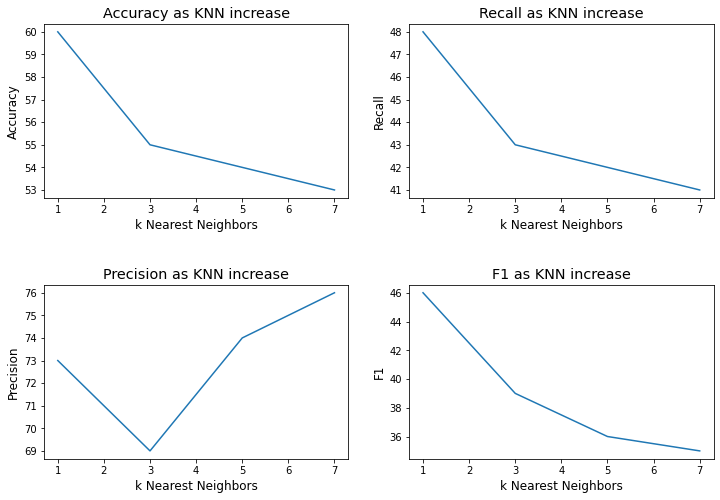

In [23]:
k_ls = [1,3,5,7] 

fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(k_ls,acc_list)
plt.title("Accuracy as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Accuracy",fontsize='large')

plt.subplot(2,2,2)
plt.plot(k_ls,rec_list)
plt.title("Recall as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Recall",fontsize='large')

plt.subplot(2,2,3)
plt.plot(k_ls,prec_list)
plt.title("Precision as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Precision",fontsize='large')

plt.subplot(2,2,4)
plt.plot(k_ls,f1_list)
plt.title("F1 as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("F1",fontsize='large')

fig.subplots_adjust(hspace=.5)

plt.show
